# Collaborative Filtering Model Testing
In this notebook, we evaluate a user-based collaborative filtering recommendation model by predicting user ratings for books and comparing them 
with the actual ratings. The steps include:

1. Constructing a user-item rating matrix using the dataset user_ratings_realistic.csv.

2. Computing cosine similarity between users to identify top-N similar users.

3. Generating predicted ratings by aggregating normalized ratings from similar users.

4. Comparing predicted ratings against actual ratings (with known ratings temporarily excluded for unbiased evaluation).


To measure the model’s performance, the following metrics are computed:

1. RMSE (Root Mean Square Error) – to evaluate average prediction error magnitude.

2. MAE (Mean Absolute Error) – for the average absolute error between predicted and actual values.

3. Precision / Recall / F1 Score – based on a relevance threshold (rating ≥ 3.0).

4. Confusion Matrix – to visualize classification performance for relevant vs. irrelevant items.

5. Prediction Error Distribution – via histogram to show how far predictions deviate.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, precision_score, recall_score, f1_score

# Import the CollaborativeFiltering class from your modified script
# Make sure the file name matches your updated script name
from collabirative import CollaborativeFiltering  # Change the import to match your file name

Loading books data...
Loading ratings data...
Columns in ratings file: ['user_id', 'isbn13', 'ratings', 'categories', 'top_category', 'is_fav_category']
Ratings before cleaning: 1000000
Ratings after cleaning: 1000000
Data Loaded: 5197 books, 3 users, 1000000 ratings.
Sample ratings data:
   user_id         isbn13  rating              categories top_category  \
0        1  9780552153577       4  Persian Gulf War, 1991      Fiction   
1        1  9780140139976       5                 Fiction      Fiction   
2        1  9780755311514       3                   Magic      Fiction   
3        1  9780786809288       2        Juvenile Fiction      Fiction   
4        1  9780515141672       5                 Fiction      Fiction   

   is_fav_category        book_id  
0            False  9780552153577  
1             True  9780140139976  
2            False  9780755311514  
3            False  9780786809288  
4             True  9780515141672  
Creating user-item matrix...
Added 1000000 rating

### 1. Load Data From CSV

In [5]:
print("Loading datasets...")
books_path = 'books_cleaned.csv'  # Path to the books dataset
users_path = 'users.csv'  # Path to the users dataset
ratings_path = 'user_ratings_realistic.csv'  # Path to the ratings dataset

# Load the data with appropriate data types
books_df = pd.read_csv(books_path, dtype={'isbn13': str})
users_df = pd.read_csv(users_path)
ratings_df = pd.read_csv(ratings_path, dtype={'isbn13': str})

# Clean and prepare the data
if 'ratings' in ratings_df.columns and 'rating' not in ratings_df.columns:
    ratings_df = ratings_df.rename(columns={'ratings': 'rating'})

ratings_df = ratings_df.dropna(subset=['user_id', 'rating'])
ratings_df['user_id'] = ratings_df['user_id'].astype(int)
ratings_df['rating'] = pd.to_numeric(ratings_df['rating'], errors='coerce')
ratings_df['book_id'] = ratings_df['isbn13']

# Display cleaned data
print("Displaying sample of ratings data:")
print(ratings_df.head())

Loading datasets...
Displaying sample of ratings data:
   user_id         isbn13  rating              categories top_category  \
0        1  9780552153577       4  Persian Gulf War, 1991      Fiction   
1        1  9780140139976       5                 Fiction      Fiction   
2        1  9780755311514       3                   Magic      Fiction   
3        1  9780786809288       2        Juvenile Fiction      Fiction   
4        1  9780515141672       5                 Fiction      Fiction   

   is_fav_category        book_id  
0            False  9780552153577  
1             True  9780140139976  
2            False  9780755311514  
3            False  9780786809288  
4             True  9780515141672  


### 2. Initialize the recommender system

In [6]:
print("Initializing recommender system...")
cf = CollaborativeFiltering()
cf.load_data(books_path, users_path, ratings_path)
cf.create_user_item_matrix()  
cf.compute_user_similarity()

Initializing recommender system...
Loading books data...
Loading ratings data...
Columns in ratings file: ['user_id', 'isbn13', 'ratings', 'categories', 'top_category', 'is_fav_category']
Ratings before cleaning: 1000000
Ratings after cleaning: 1000000
Data Loaded: 5197 books, 3 users, 1000000 ratings.
Sample ratings data:
   user_id         isbn13  rating              categories top_category  \
0        1  9780552153577       4  Persian Gulf War, 1991      Fiction   
1        1  9780140139976       5                 Fiction      Fiction   
2        1  9780755311514       3                   Magic      Fiction   
3        1  9780786809288       2        Juvenile Fiction      Fiction   
4        1  9780515141672       5                 Fiction      Fiction   

   is_fav_category        book_id  
0            False  9780552153577  
1             True  9780140139976  
2            False  9780755311514  
3            False  9780786809288  
4             True  9780515141672  
Creating user-

### 3. Examine user-item matrix shape

In [7]:
print(f"User-item matrix shape: {cf.user_item_matrix.shape}")

User-item matrix shape: (500, 5195)


### 4. Visualize a subset of the user-item matrix

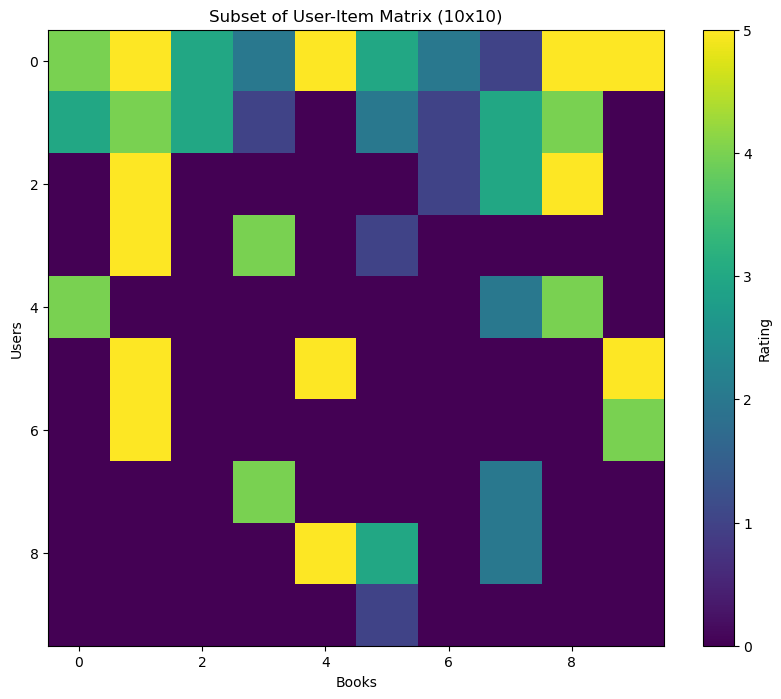

In [52]:
plt.figure(figsize=(10, 8))
plt.imshow(cf.user_item_matrix[:10, :10], cmap='viridis')
plt.colorbar(label='Rating')
plt.title('Subset of User-Item Matrix (10x10)')
plt.xlabel('Books')
plt.ylabel('Users')
plt.show()

### 5. Test getting similar users

In [9]:
test_user_id = 1
similar_users = cf.get_similar_users(test_user_id, top_n=5)
print(f"Similar users to user {test_user_id}:")
for user_id, similarity in similar_users:
    print(f"User {user_id}: Similarity = {similarity:.4f}")

Getting similar users for user 1...
Similar users found: [(65, 0.39541703920470667), (151, 0.39339912642116165), (495, 0.3928561858827802), (94, 0.3928204163782966), (406, 0.38601017141950356)]
Similar users to user 1:
User 65: Similarity = 0.3954
User 151: Similarity = 0.3934
User 495: Similarity = 0.3929
User 94: Similarity = 0.3928
User 406: Similarity = 0.3860


### 6. Test recommendation functionality

In [10]:
print(f"\nGetting recommendations for user {test_user_id}:")
# First, generate all recommendations for the user
cf.generate_recommendations(test_user_id, max_recommendations=50)
# Then get the first page of recommendations
recommendations = cf.get_paginated_recommendations(0)  # Get first page (index 0)
print(f"Number of recommendations: {len(recommendations)}")

# Display recommendations in a more readable format
print("\nTop Recommendations:")
for i, (thumbnail, description) in enumerate(recommendations, 1):
    print(f"{i}. {description}")
    print("-" * 80)


Getting recommendations for user 1:
Looking up recommendations for user 1
User has rated 1953 books
Found 3242 candidate books for recommendation
Number of recommendations: 10

Top Recommendations:
1. Desecration by Tim F. LaHaye;Jerry B. Jenkins - Fiction (Predicted Rating: 5.0)
--------------------------------------------------------------------------------
2. Wideacre by Philippa Gregory - Fiction (Predicted Rating: 5.0)
--------------------------------------------------------------------------------
3. Gargantua and Pantagruel by François Rabelais - Fiction (Predicted Rating: 5.0)
--------------------------------------------------------------------------------
4. Sexus by Henry Miller - Fiction (Predicted Rating: 4.95)
--------------------------------------------------------------------------------
5. Dates From Hell by Kim Harrison;Lynsay Sands;Kelley Armstrong;Lori Handeland - Fiction (Predicted Rating: 4.95)
----------------------------------------------------------------------

### 7. Test recommendation for another user

In [11]:
another_user_id = 2
print(f"\nGetting recommendations for user {another_user_id}:")
# First, generate all recommendations for the user

cf.generate_recommendations(another_user_id, max_recommendations=50)
# Then get the first page of recommendations
recommendations_2 = cf.get_paginated_recommendations(0)  # Get first page
print("\nTop Recommendations for User 2:")
for i, (thumbnail, description) in enumerate(recommendations_2, 1):
    print(f"{i}. {description}")
    print("-" * 80)
    


Getting recommendations for user 2:
Looking up recommendations for user 2
User has rated 1992 books
Found 3203 candidate books for recommendation

Top Recommendations for User 2:
1. Gun, with Occasional Music by Jonathan Lethem - Fiction (Predicted Rating: 5.0)
--------------------------------------------------------------------------------
2. The Dharma Bums by Jack Kerouac - Fiction (Predicted Rating: 5.0)
--------------------------------------------------------------------------------
3. Lights Out by Peter Abrahams - Fiction (Predicted Rating: 5.0)
--------------------------------------------------------------------------------
4. In Conquest Born by C. S. Friedman - Fiction (Predicted Rating: 5.0)
--------------------------------------------------------------------------------
5. Up In a Heaval by Piers Anthony - Fiction (Predicted Rating: 4.95)
--------------------------------------------------------------------------------
6. The Secret Swan by Shana Abé - Fiction (Predicted Ra

# Measure Model Performance

In [44]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity

###  Select a subset of users and books for evaluation

In [45]:
print("\nEvaluating improved recommender system...")
test_users = list(cf.user_indices.keys())[:10]  # First 10 users
test_predictions = []
test_actual = []


Evaluating improved recommender system...


### Calculate user mean ratings for normalization

In [46]:
user_means = np.zeros(cf.user_item_matrix.shape[0])
for u_idx in range(cf.user_item_matrix.shape[0]):
    ratings = cf.user_item_matrix[u_idx]
    # Only consider actual ratings (>0) for mean calculation
    actual_ratings = ratings[ratings > 0]
    user_means[u_idx] = np.mean(actual_ratings) if len(actual_ratings) > 0 else 0

### Step 1: Loop through a sample of users
We iterate over a sample of test users and retrieve the books they've rated. For each rating, we aim to predict it using collaborative filtering and compare it against the actual rating.

In [47]:
# For each user, get predictions for books they've rated
for user_id in test_users:
    user_idx = cf.user_indices.get(user_id)
    if user_idx is None:
        continue
        
    user_ratings = ratings_df[ratings_df['user_id'] == user_id]
    

### Step 2: Limit to 5 books per user
To speed up the evaluation process, we only use the first 5 rated books for each user.


### Step 3: Prevent data leakage
Temporarily remove the current rating from the matrix to avoid using it in the prediction process.


### Step 4: Recompute similarity matrix
We create a temporary CollaborativeFiltering object and compute the similarity matrix again without the target rating.


### Step 5: Identify top-N similar users
We find the top n most similar users (excluding the current user) based on cosine similarity.


### Step 6: Normalize ratings for prediction
Extract ratings from similar users for the target book, normalize them by subtracting each user's mean rating, and prepare for weighted prediction.


### Step 7: Compute the weighted prediction or fallback to global average
If enough data is available, calculate a weighted average prediction. If not, use global average for that book.


### Step 8: Store predictions and print examples
Append the predicted and actual ratings to their respective lists. Also, display the first few prediction examples.


User 10, Book 9780141441115: Predicted = 5.00, Actual = 5
User 10, Book 9780425164174: Predicted = 2.52, Actual = 3
User 10, Book 9780060815523: Predicted = 2.69, Actual = 2
User 10, Book 9780590692083: Predicted = 2.24, Actual = 1
User 10, Book 9780802135780: Predicted = 4.77, Actual = 5


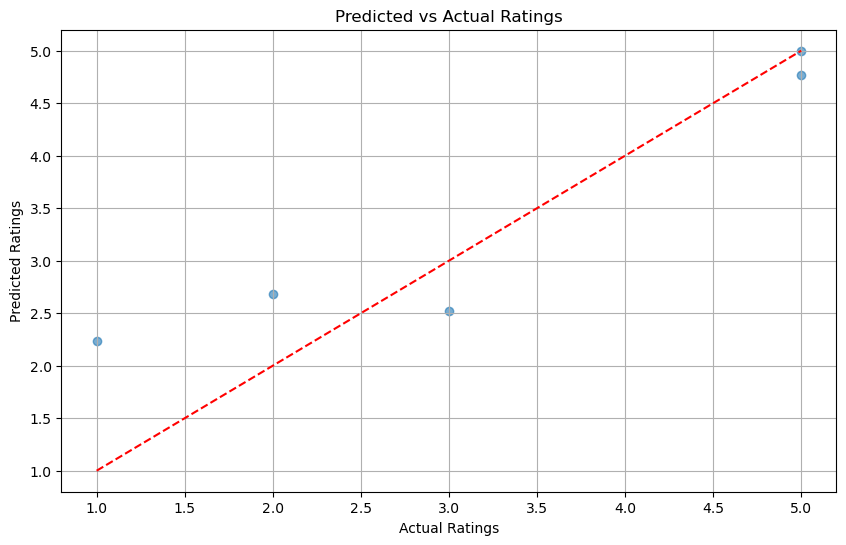

In [51]:
# Initialize prediction lists outside the loop
test_predictions = []
test_actual = []

# Limit to first 5 ratings for faster evaluation
for _, row in user_ratings.iloc[:5].iterrows():
    book_id = row['book_id']
    actual_rating = row['rating']
    book_idx = cf.book_indices.get(book_id)
    
    if book_idx is None:
        continue

    temp_matrix = cf.user_item_matrix.copy()
    temp_matrix[user_idx, book_idx] = 0

    temp_cf = copy.deepcopy(cf)
    temp_cf.user_item_matrix = temp_matrix
    temp_cf.similarity_matrix = cosine_similarity(temp_matrix)

    N = 20
    similarities = temp_cf.similarity_matrix[user_idx].copy()
    similarities[user_idx] = -1
    top_indices = np.argsort(similarities)[-N:]
    top_similarities = similarities[top_indices]
    top_ratings = temp_matrix[top_indices, book_idx]
    rated_mask = top_ratings > 0

    if np.sum(rated_mask) > 0:
        normalized_ratings = np.zeros_like(top_ratings)
        for i, u_idx in enumerate(top_indices):
            if top_ratings[i] > 0:
                normalized_ratings[i] = top_ratings[i] - user_means[u_idx]
        numerator = np.sum(top_similarities[rated_mask] * normalized_ratings[rated_mask])
        denominator = np.sum(np.abs(top_similarities[rated_mask])) + 1e-10
        predicted_rating = user_means[user_idx] + (numerator / denominator)
        predicted_rating = min(max(predicted_rating, 1), 5)
    else:
        global_ratings = temp_matrix[:, book_idx]
        actual_global_ratings = global_ratings[global_ratings > 0]
        predicted_rating = np.mean(actual_global_ratings) if len(actual_global_ratings) > 0 else 3.0

    test_predictions.append(predicted_rating)
    test_actual.append(actual_rating)

    if len(test_predictions) <= 5:
        print(f"User {user_id}, Book {book_id}: Predicted = {predicted_rating:.2f}, Actual = {actual_rating}")

plt.figure(figsize=(10, 6))
plt.scatter(test_actual, test_predictions, alpha=0.6)
plt.plot([1, 5], [1, 5], 'r--') 
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Predicted vs Actual Ratings')
plt.grid(True)
plt.show()


## Calculate RMSE , MAE and Precision, Recall and F1 Score 

In [37]:
# Calculate RMSE
if test_predictions:
    rmse = np.sqrt(mean_squared_error(test_actual, test_predictions))
    print(f"\nRMSE for the recommender system: {rmse:.4f}")
    
    # Calculate MAE
    mae = mean_absolute_error(test_actual, test_predictions)
    print(f"MAE for the recommender system: {mae:.4f}")
    
    # Calculate Precision, Recall, and F1 Score (threshold of 3.0 for relevance)
    threshold = 3.0
    predicted_relevant = [1 if pred >= threshold else 0 for pred in test_predictions]
    actual_relevant = [1 if actual >= threshold else 0 for actual in test_actual]


RMSE for the recommender system: 0.6767
MAE for the recommender system: 0.5278


In [32]:
# Plot predictions vs actual ratings
plt.figure(figsize=(10, 6))
plt.scatter(test_actual, test_predictions, alpha=0.6)
plt.plot([1, 5], [1, 5], 'r--')  # Perfect prediction line
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Predicted vs Actual Ratings')
plt.grid(True)
plt.savefig('prediction_vs_actual.png')
plt.close()
    
# Handle possible zero division
try:
    precision = precision_score(actual_relevant, predicted_relevant)
    recall = recall_score(actual_relevant, predicted_relevant)
    f1 = f1_score(actual_relevant, predicted_relevant)
        
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
        
    # Create confusion matrix
    cm = confusion_matrix(actual_relevant, predicted_relevant)
    print("\nConfusion Matrix:")
    print(cm)
        
except Exception as e:
    print(f"Error calculating metrics: {e}")
    print("This can happen if all predictions or actuals belong to a single class")

Precision: 1.0000
Recall: 0.6667
F1 Score: 0.8000

Confusion Matrix:
[[10  0]
 [ 5 10]]


### Additional evaluation - distribution of errors

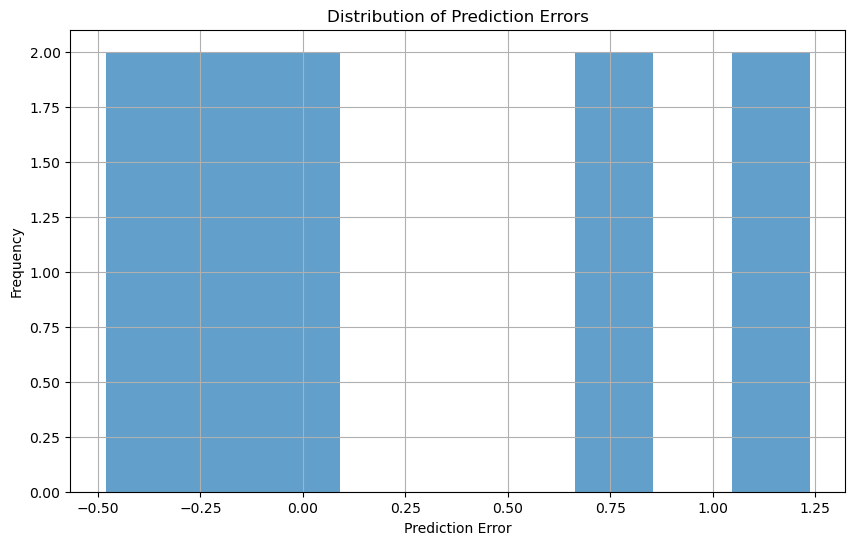


Error Statistics:
Mean Error: 0.2421
Standard Deviation of Error: 0.6319
Min Error: -0.4815
Max Error: 1.2374


In [50]:
if test_predictions:
    errors = np.array(test_predictions) - np.array(test_actual)
    
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=9, alpha=0.7)
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.title('Distribution of Prediction Errors')
    plt.grid(True)
    plt.show()
    
    print("\nError Statistics:")
    print(f"Mean Error: {np.mean(errors):.4f}")
    print(f"Standard Deviation of Error: {np.std(errors):.4f}")
    print(f"Min Error: {np.min(errors):.4f}")
    print(f"Max Error: {np.max(errors):.4f}")


Analyzing ratings for book ID 9780552153577:


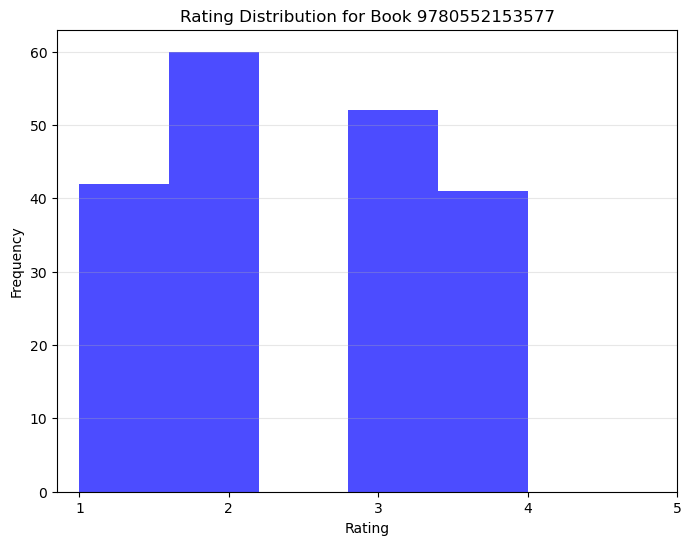

Number of ratings: 195
Average rating: 2.47
Rating distribution:
rating
1    42
2    60
3    52
4    41
Name: count, dtype: int64


In [34]:
import matplotlib.pyplot as plt

# Sample book ID to analyze
sample_book_id = "9780552153577"  # The book ID used in the notebook example
book_ratings = ratings_df[ratings_df['book_id'] == sample_book_id]

print(f"\nAnalyzing ratings for book ID {sample_book_id}:")
if not book_ratings.empty:
    plt.figure(figsize=(8, 6))
    plt.hist(book_ratings['rating'], bins=5, alpha=0.7, color='blue')
    plt.title(f'Rating Distribution for Book {sample_book_id}')
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.xticks([1, 2, 3, 4, 5])
    plt.grid(axis='y', alpha=0.3)
    
    # Display the plot here instead of saving it
    plt.show()  # Display the plot in the notebook

    # Print rating statistics
    print(f"Number of ratings: {len(book_ratings)}")
    print(f"Average rating: {book_ratings['rating'].mean():.2f}")
    print(f"Rating distribution:")
    print(book_ratings['rating'].value_counts().sort_index())
else:
    print(f"No ratings found for book ID {sample_book_id}")
